### https://www.kaggle.com/code/shubhijoshi/similar-image-finder-using-k-means

# Dwonload data

In [8]:
# ! pip install kaggle --upgrade
! cd notebooks/xai-survey && ls && kaggle datasets download -d paramaggarwal/fashion-product-images-small

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
 All_ref_500.csv   clusters-embeddings	 intents_500.xlsx
 archive.zip	   Data.xlsx		'RC6 nodes info(Abstract).xlsx'
 art_dataset	   HMRServer.jar	'RC6 nodes info.xlsx'
100%|███████████████████████████████████████▉| 565M/565M [00:51<00:00, 11.7MB/s]
100%|████████████████████████████████████████| 565M/565M [00:51<00:00, 11.5MB/s]


In [1]:
# ! apt-get install unzip
! cd notebooks/xai-survey && unzip fashion-product-images-small.zip

Archive:  fashion-product-images-small.zip
  inflating: images/10000.jpg        
  inflating: images/10001.jpg        
  inflating: images/10002.jpg        
  inflating: images/10003.jpg        
  inflating: images/10004.jpg        
  inflating: images/10005.jpg        
  inflating: images/10006.jpg        
  inflating: images/10007.jpg        
  inflating: images/10008.jpg        
  inflating: images/10009.jpg        
  inflating: images/10010.jpg        
  inflating: images/10011.jpg        
  inflating: images/10012.jpg        
  inflating: images/10013.jpg        
  inflating: images/10014.jpg        
  inflating: images/10015.jpg        
  inflating: images/10016.jpg        
  inflating: images/10017.jpg        
  inflating: images/10018.jpg        
  inflating: images/10019.jpg        
  inflating: images/10020.jpg        
  inflating: images/10021.jpg        
  inflating: images/10022.jpg        
  inflating: images/10023.jpg        
  inflating: images/10024.jpg        
  infla

In [5]:
! cd notebooks/xai-survey && ls

 All_ref_500.csv		    images
 art_dataset			    intents_500.xlsx
 clusters-embeddings		    myntradataset
 Data.xlsx			   'RC6 nodes info(Abstract).xlsx'
 fashion-product-images-small.zip  'RC6 nodes info.xlsx'
 HMRServer.jar			    styles.csv


# Importing Libraries

In [4]:
! pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import datetime
import sys

print(f"UTC now= '{datetime.datetime.utcnow().isoformat().split('.')[0]}'")
print(f'Virtualenv used: {sys.executable}')

import importlib


import numpy as np
import pandas as pd
import ast
import pickle
import math

from pathlib import Path

from sklearn.cluster import KMeans

#for text pre-processing
import re, string

from sklearn.decomposition import TruncatedSVD
# bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
#for model-building
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree

from sentence_transformers import SentenceTransformer
sentence_bert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

import spacy
importlib.reload(spacy)
spacy_nlp_model = spacy.load('en_core_web_lg')

from scipy.optimize import minimize_scalar

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
#
# # Initialize the lemmatizer
# wl = WordNetLemmatizer()

from nltk.corpus import wordnet, stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for LIME import necessary packages
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from random import randint

from typing import List, Optional

UTC now= '2022-05-14T17:40:38'
Virtualenv used: /usr/bin/python3


In [144]:
def _save_pickle(df, outfile, results_folder):
  if results_folder:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/{results_folder}"
    # results_folder_local = results_folder
  else:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/data"
  Path(results_folder_local).mkdir(parents=True, exist_ok=True)
  fname = f"{results_folder_local}/{outfile}.pickle"
  print(fname)
  with open(fname, 'wb') as f:
    pickle.dump(df, f)


def _read_pandas_pickle(infile, data_folder):
  fname = f'{data_folder}/{infile}.pickle'
  return pd.read_pickle(fname)


def get_LSA_chunks(df:pd.DataFrame, column_to_omit:str, how_many_dimension:int, random_subsample:Optional[float]) -> Optional[pd.DataFrame]:
    svd = TruncatedSVD(how_many_dimension)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    if random_subsample:
      _df = df.sample(frac=random_subsample)
      print(f"using {len(_df.index)} observations")
      lsa.fit(_df.loc[:, df.columns != column_to_omit])
    else:
      lsa.fit(df.loc[:, df.columns != column_to_omit])
    print(f"explained variance perc = {svd.explained_variance_ratio_.sum()*100}%")

    chunk_size = 1_000
    rows_count = len(df.index)
    chunks = list()
    num_chunks = rows_count // chunk_size + 1
    for i in range(num_chunks):
      print(f"processing chunk {str(i)} of {str(num_chunks)}")
      chunks.append(pd.DataFrame(lsa.transform(df.loc[i*chunk_size : min(rows_count-1, (i+1)*chunk_size-1), df.columns != column_to_omit])))
    _df_lsa = pd.concat(chunks, axis=0)
    _df_lsa[column_to_omit] = df[column_to_omit]

    _df_lsa = _df_lsa.reset_index()
    del _df_lsa['index']

    return _df_lsa


def get_TSNE_and_PCA_embeddings(df:pd.DataFrame, column_to_omit:str, random_subsample:Optional[float]):
  if random_subsample:
    _df = df.sample(frac=random_subsample)
    print(f"using {len(_df.index)} observations")
    df_independent_vars = _df.loc[:, (df.columns != column_to_omit) & (df.columns != 'cluster_kmeans')]
  else:
    df_independent_vars = df.loc[:, (df.columns != column_to_omit) & (df.columns != 'cluster_kmeans')]

  df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_independent_vars))
  df_tsne['cluster'] = df['cluster_kmeans']
  df_tsne.columns = ['x1', 'x2', 'cluster']
  df_tsne[column_to_omit] = df[column_to_omit]

  df_pca = pd.DataFrame(PCA(n_components=2).fit_transform(df_independent_vars))
  df_pca['cluster'] = df['cluster_kmeans']
  df_pca.columns = ['x1', 'x2', 'cluster']
  df_pca[column_to_omit] = df[column_to_omit]

  scaler = MinMaxScaler()
  df_tsne[['x1', 'x2']] = scaler.fit_transform(df_tsne[['x1', 'x2']])
  df_pca[['x1', 'x2']] = scaler.fit_transform(df_pca[['x1', 'x2']])

  return df_tsne, df_pca


def k_means(df, column_to_omit, how_many_clusters):
  kmeans = KMeans(n_clusters=how_many_clusters, random_state=2022).fit(df.loc[:, (df.columns != column_to_omit) & (df.columns != 'cluster_kmeans')])
  df['cluster_kmeans'] = kmeans.labels_
  return df


In [5]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil


# Loading data

In [6]:
input_dir = 'notebooks/xai-survey/images'
glob_dir = input_dir + '/*.jpg'
temp  = glob.glob(glob_dir)
print(len(temp))

44441


(44441, 128, 128, 3)


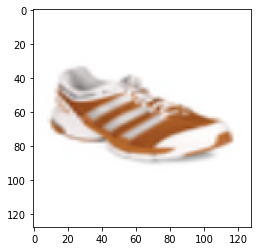

In [7]:
selected_images= temp#[0:1000]
paths = [file for file in selected_images]
images = [cv2.resize(cv2.imread(file), (128, 128)) for file in selected_images]
images = np.array(np.float32(images).reshape(len(images),images[0].shape[0],images[0].shape[1],images[0].shape[2])/255)
print(images.shape)
plt.imshow(images[10])

In [8]:
128 * 128 * 3

49152

In [9]:
# Getting embedded data
## embedding
model = tf.keras.applications.MobileNetV2(include_top = False, weights='imagenet', input_shape=(128, 128, 3))
predictions = model.predict(images.reshape(-1, 128, 128, 3)) ## representation of image to reduce size
pred_images = predictions.reshape(images.shape[0], -1) ## reshape
pred_images.shape

2022-05-14 19:41:05.523865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 19:41:05.537132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mmozolewski/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.0/lib64:
2022-05-14 19:41:05.539741: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-14 19:41:05.540432: I tensorflow/

(44441, 20480)

In [10]:
pd.DataFrame(pred_images[:10])

0         1      2        3         4         5         6         7      \
0  0.000000  0.000000    0.0  0.00000  0.000000  3.490847  1.975876  0.203021   
1  0.000000  0.000000    0.0  0.00000  1.097074  0.000000  0.000000  0.000000   
2  0.000000  0.000000    0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000    0.0  0.00000  1.674848  0.000000  0.000000  0.000000   
4  0.000000  0.000000    0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
5  0.611750  0.000000    0.0  1.41979  4.280862  0.000000  0.000000  0.000000   
6  0.226754  0.184644    0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000    0.0  0.00000  1.509722  0.000000  0.000000  0.000000   
8  0.000000  0.000000    0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000    0.0  0.00000  1.239510  0.000000  0.000000  0.000000   

   8         9      ...     20470     20471     20472     20473     20474  \
0    0.0  4.109615  ...  0.000000  0.000000  0.000000  0.000000  0.794228   
1    0.0  1.013652  ...  0.194866  0.266604  0.155169  0.000000  0.000000   
2    0.0  0.000000  ...  0.023009  0.000000  0.000000  0.834312  0.414808   
3    0.0  2.789933  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.0  3.851412  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
5    0.0  6.000000  ...  0.000000  0.000000  0.958634  0.000000  1.276356   
6    0.0  0.807682  ...  0.000000  0.000000  0.000000  0.642143  0.000000   
7    0.0  0.050617  ...  0.000000  1.896831  0.000000  0.000000  0.000000   
8    0.0  0.000000  ...  0.000000  0.354670  0.000000  0.000000  0.000000   
9    0.0  1.782197  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

   20475  20476  20477     20478     20479  
0    0.0    0.0    0.0  0.000000  0.000000  
1    0.0    0.0    0.0  0.000000  0.000000  
2    0.0    0.0    0.0  0.000000  0.517837  
3    0.0    0.0    0.0  0.000000  0.000000  
4    0.0    0.0    0.0  0.438278  0.000000  
5    0.0    0.0    0.0  0.000000  0.000000  
6    0.0    0.0    0.0  0.000000  0.000000  
7    0.0    0.0    0.0  0.000000  0.000000  
8    0.0    0.0    0.0  0.000000  0.000000  
9    0.0    0.0    0.0  0.000000  0.000000  

[10 rows x 20480 columns]

# Metadata

In [11]:
# CSV is broken, need to read it manually
file1 = open('notebooks/xai-survey/styles.csv', 'r')
_metadata = []
while True:
  # Get next line from file
  line = file1.readline()

  # if line is empty
  # end of file is reached
  if not line:
    break
  _metadata.append(line.strip().split(',', 9))
  # break
file1.close()

df_metadata = pd.DataFrame(_metadata[1:])
df_metadata.columns = _metadata[0]
df_metadata

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44441  17036    Men       Footwear       Shoes           Casual Shoes   
44442   6461    Men       Footwear  Flip Flops             Flip Flops   
44443  18842    Men        Apparel     Topwear                Tshirts   
44444  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44445  51623  Women    Accessories     Watches                Watches   

      baseColour  season  year   usage  \
0      Navy Blue    Fall  2011  Casual   
1           Blue  Summer  2012  Casual   
2         Silver  Winter  2016  Casual   
3          Black    Fall  2011  Casual   
4           Grey  Summer  2012  Casual   
...          ...     ...   ...     ...   
44441      White  Summer  2013  Casual   
44442        Red  Summer  2011  Casual   
44443       Blue    Fall  2011  Casual   
44444       Blue  Spring  2017  Casual   
44445       Pink  Winter  2016  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44441                        Gas Men Caddy Casual Shoe  
44442               Lotto Men's Soccer Track Flip Flop  
44443             Puma Men Graphic Stellar Blue Tshirt  
44444                   Rasasi Women Blue Lady Perfume  
44445  Fossil Women Pink Dial Chronograph Watch ES3050  

[44446 rows x 10 columns]

In [12]:
df_image_embeddings = pd.DataFrame(pred_images)
df_image_embeddings['id'] = [id.replace('notebooks/xai-survey/images/', '').replace('.jpg', '') for id in selected_images]
# df_image_embeddings.tail()
df_image_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Columns: 20481 entries, 0 to id
dtypes: float32(20480), object(1)
memory usage: 3.4+ GB


In [13]:
_save_pickle(df_image_embeddings, 'df_image_embeddings', 'data')

/home/mmozolewski/data/df_image_embeddings.pickle


In [20]:
df_metadata_merge_test = pd.merge(df_metadata, df_image_embeddings[['id', 0, 1]], on="id")
# df_metadata_merge_test.tail()
df_metadata_merge_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44441 entries, 0 to 44440
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  object 
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44441 non-null  object 
 6   season              44441 non-null  object 
 7   year                44441 non-null  object 
 8   usage               44441 non-null  object 
 9   productDisplayName  44441 non-null  object 
 10  0                   44441 non-null  float32
 11  1                   44441 non-null  float32
dtypes: float32(2), object(10)
memory usage: 4.1+ MB


id gender masterCategory subCategory articleType baseColour  season  \
5852  43849  Women    Accessories   Jewellery    Earrings      Green  Summer   

      year   usage                   productDisplayName    0    1  
5852  2012  Ethnic  Royal Diadem White & Green Earrings  0.0  0.0

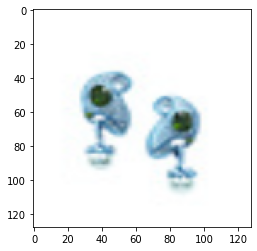

In [21]:
_test_N = 8889
_id = selected_images[_test_N].replace('notebooks/xai-survey/images/', '').replace('.jpg', '')
plt.imshow(images[_test_N])
df_metadata_merge_test.loc[df_metadata_merge_test['id'] == _id, ]


# LSA

In [104]:
# df_image_embeddings = _read_pandas_pickle('df_image_embeddings', 'data')
df_image_embeddings_lsa = get_LSA_chunks(df_image_embeddings, 'id', 3000, None)

explained variance perc = 93.19400191307068%
processing chunk 0 of 45
processing chunk 1 of 45
processing chunk 2 of 45
processing chunk 3 of 45
processing chunk 4 of 45
processing chunk 5 of 45
processing chunk 6 of 45
processing chunk 7 of 45
processing chunk 8 of 45
processing chunk 9 of 45
processing chunk 10 of 45
processing chunk 11 of 45
processing chunk 12 of 45
processing chunk 13 of 45
processing chunk 14 of 45
processing chunk 15 of 45
processing chunk 16 of 45
processing chunk 17 of 45
processing chunk 18 of 45
processing chunk 19 of 45
processing chunk 20 of 45
processing chunk 21 of 45
processing chunk 22 of 45
processing chunk 23 of 45
processing chunk 24 of 45
processing chunk 25 of 45
processing chunk 26 of 45
processing chunk 27 of 45
processing chunk 28 of 45
processing chunk 29 of 45
processing chunk 30 of 45
processing chunk 31 of 45
processing chunk 32 of 45
processing chunk 33 of 45
processing chunk 34 of 45
processing chunk 35 of 45
processing chunk 36 of 45
pro

In [105]:
df_image_embeddings_lsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44441 entries, 0 to 440
Columns: 3001 entries, 0 to id
dtypes: float32(3000), object(1)
memory usage: 509.3+ MB


In [106]:
df_image_embeddings_lsa.tail()

0         1         2         3         4         5         6  \
436  0.559954  0.364917 -0.179992 -0.091733  0.140237 -0.063016 -0.286902   
437  0.420162  0.028004  0.214292  0.107756 -0.085164  0.196511  0.130418   
438  0.621431 -0.227731  0.001352 -0.146910 -0.194127 -0.013892 -0.056185   
439  0.674395 -0.162091 -0.023080 -0.063712 -0.111595 -0.148993 -0.001704   
440  0.534300  0.429839 -0.251841 -0.156944  0.108760  0.147136 -0.059328   

            7         8         9  ...      2991      2992      2993  \
436 -0.152078  0.041419  0.145346  ...  0.004641  0.000931 -0.004806   
437 -0.061460 -0.042054  0.191182  ...  0.000825 -0.009454 -0.003252   
438 -0.049096  0.045114  0.031365  ...  0.000603  0.008388 -0.002408   
439 -0.131707  0.026660  0.023304  ... -0.000787 -0.005180  0.008439   
440  0.058154  0.041748 -0.044857  ... -0.006972  0.004428 -0.001783   

         2994      2995      2996      2997      2998      2999     id  
436 -0.004718  0.003189  0.004329 -0.003203 -0.012403 -0.008961  38017  
437 -0.000754  0.004655  0.005788 -0.002678 -0.008333  0.002897  32600  
438  0.006742  0.001598 -0.004608 -0.003659 -0.005069 -0.000514   8231  
439  0.007936  0.002866  0.002576  0.006113 -0.001886 -0.000922  38544  
440  0.001465 -0.008949 -0.001531  0.005422 -0.002454 -0.001796  14100  

[5 rows x 3001 columns]

In [143]:
_save_pickle(df_image_embeddings_lsa.loc[:, df_image_embeddings_lsa.columns != 'cluster_kmeans'], 'df_image_embeddings_lsa', 'data')

/home/mmozolewski/data/df_image_embeddings_lsa.pickle


# Plotting Silhoutte
To find optimal k in k means

In [113]:
df_image_embeddings_lsa_no_id_sample = df_image_embeddings_lsa.loc[:, df_image_embeddings_lsa.columns != 'id'].sample(frac=.10)

In [114]:
#### Plotting Silhoutte score to find optimal K
sil = []
kl = []
kmax = 50

for k in range(2, kmax+1):
  print(k)
  kmeans2 = KMeans(n_clusters = k,random_state = 0).fit(df_image_embeddings_lsa_no_id_sample)
  labels = kmeans2.labels_
  sil.append(silhouette_score(df_image_embeddings_lsa_no_id_sample, labels))
  kl.append(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


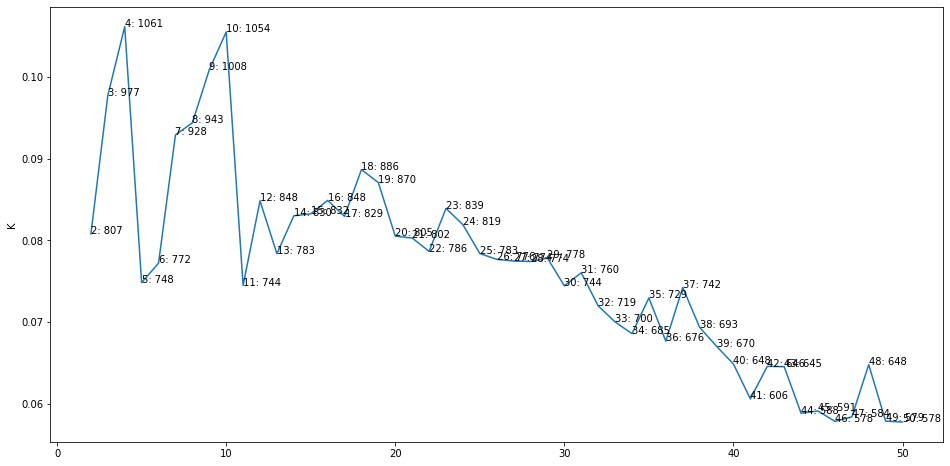

In [125]:
plt.figure(figsize=(16, 8))
plt.plot(kl, sil)
plt.ylabel('Silhoutte Score')
plt.ylabel('K')
for a,b in zip(kl, sil):
  plt.text(a, b, str(a) + ": " + str(int(b*10000)))
plt.show()

# Training K-means
Here maximum is at k = 3 . But as this is fashion dataset so there can be many different types of clusters like based on gender , top or bottom etc. So, for this dataset k = 3 don't seems to be sufficient so choosing k = 8

In [ ]:
N_CLUSTERS = 10

# df_image_embeddings_lsa_no_id = df_image_embeddings_lsa.loc[:, df_image_embeddings_lsa.columns != 'id']
df_image_embeddings_lsa = k_means(df_image_embeddings_lsa, 'id', N_CLUSTERS)

# kmodel = KMeans(n_clusters=N_CLUSTERS, n_jobs=-1, random_state = 2022) #change random state any value
# kmodel.fit(df_image_embeddings_lsa_no_id) ### training kmean
# kpredictions = kmodel.predict(df_image_embeddings_lsa_no_id) ###prediction
####
# df_image_embeddings_lsa['cluster_kmeans'] = kpredictions

In [138]:
df_image_embeddings_lsa

0         1         2         3         4         5         6  \
0      0.487381  0.052084  0.229442 -0.218109  0.315353  0.049023  0.193767   
1      0.637489 -0.144028  0.118767 -0.088406 -0.202195 -0.102049  0.023162   
2      0.559329 -0.185414 -0.016003  0.090072  0.060129  0.062253  0.048365   
3      0.668110 -0.361191 -0.069626 -0.158994 -0.121511 -0.136943  0.023327   
4      0.598770 -0.272693 -0.042998 -0.030101 -0.110983  0.004072 -0.040917   
...         ...       ...       ...       ...       ...       ...       ...   
44436  0.559954  0.364917 -0.179992 -0.091733  0.140237 -0.063016 -0.286902   
44437  0.420162  0.028004  0.214292  0.107756 -0.085164  0.196511  0.130418   
44438  0.621431 -0.227731  0.001352 -0.146910 -0.194127 -0.013892 -0.056185   
44439  0.674395 -0.162091 -0.023080 -0.063712 -0.111595 -0.148993 -0.001704   
44440  0.534300  0.429839 -0.251841 -0.156944  0.108760  0.147136 -0.059328   

              7         8         9  ...      2992      2993      2994  \
0     -0.124464  0.035369  0.037994  ... -0.001899  0.002080  0.001136   
1     -0.118199 -0.002745 -0.074946  ... -0.005946  0.006419  0.000774   
2     -0.221368 -0.034722  0.014664  ... -0.004636  0.003764  0.003318   
3     -0.040087 -0.048553 -0.027022  ... -0.003946  0.008222 -0.001561   
4     -0.011312 -0.052248  0.046284  ... -0.000013 -0.000362 -0.001566   
...         ...       ...       ...  ...       ...       ...       ...   
44436 -0.152078  0.041419  0.145346  ...  0.000931 -0.004806 -0.004718   
44437 -0.061460 -0.042054  0.191182  ... -0.009454 -0.003252 -0.000754   
44438 -0.049096  0.045114  0.031365  ...  0.008388 -0.002408  0.006742   
44439 -0.131707  0.026660  0.023304  ... -0.005180  0.008439  0.007936   
44440  0.058154  0.041748 -0.044857  ...  0.004428 -0.001783  0.001465   

           2995      2996      2997      2998      2999     id  cluster_kmeans  
0      0.007390 -0.000711 -0.000807 -0.005500  0.000850  48395               7  
1      0.003859 -0.000965 -0.001436  0.002911  0.001483  19989               1  
2     -0.006488  0.002032  0.005927 -0.002716 -0.000493  48400               4  
3      0.003201 -0.003813  0.005760  0.004275  0.001664  46272               1  
4      0.008373  0.003399 -0.006568  0.007703 -0.003845   3131               1  
...         ...       ...       ...       ...       ...    ...             ...  
44436  0.003189  0.004329 -0.003203 -0.012403 -0.008961  38017               3  
44437  0.004655  0.005788 -0.002678 -0.008333  0.002897  32600               9  
44438  0.001598 -0.004608 -0.003659 -0.005069 -0.000514   8231               1  
44439  0.002866  0.002576  0.006113 -0.001886 -0.000922  38544               1  
44440 -0.008949 -0.001531  0.005422 -0.002454 -0.001796  14100               2  

[44441 rows x 3002 columns]

In [149]:
df_image_embeddings_lsa_tsne, df_image_embeddings_lsa_pca = get_TSNE_and_PCA_embeddings(df_image_embeddings_lsa, 'id', random_subsample=None)

<AxesSubplot:title={'center':'Images clustering - MobileNetV2 embeddings, LSA (>90% variance)'}, xlabel='x1', ylabel='x2'>

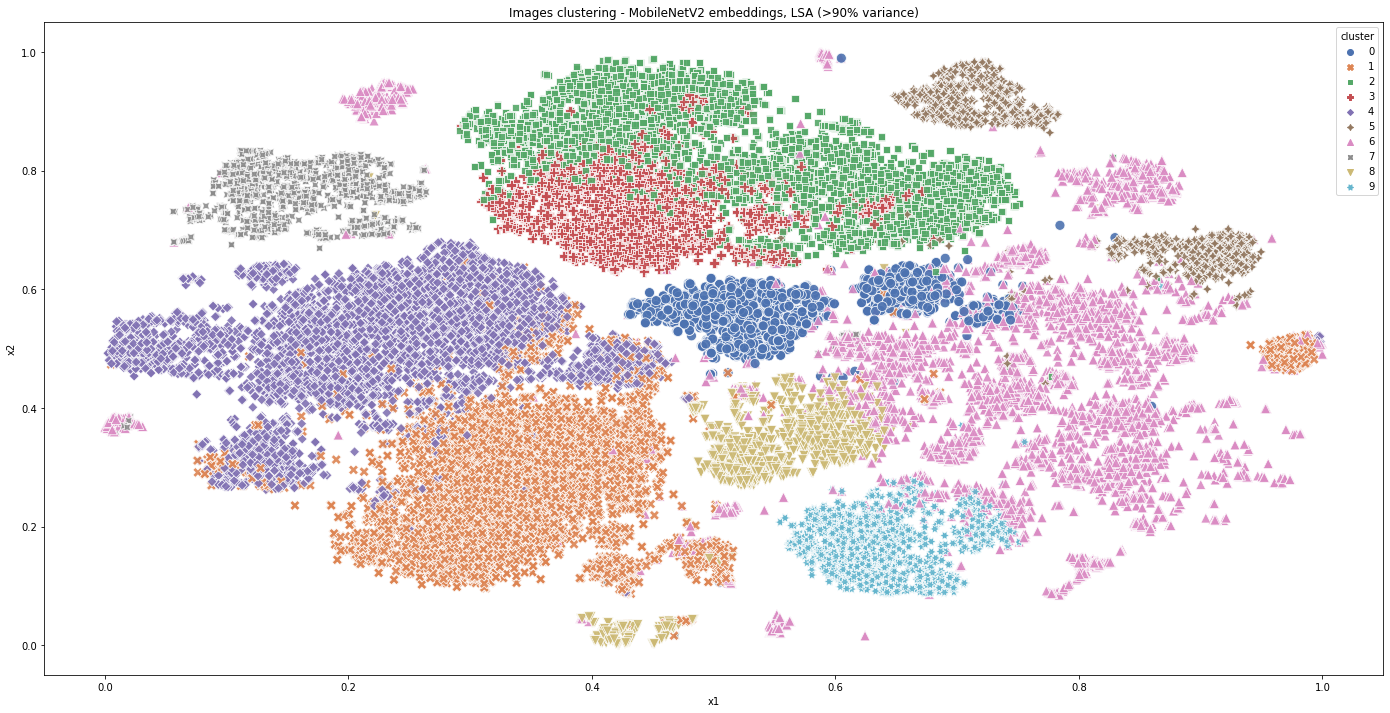

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(12*2,6*2))
ax.set_title('Images clustering - MobileNetV2 embeddings, LSA (>90% variance)')
sns.scatterplot(data=df_image_embeddings_lsa_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)

<AxesSubplot:title={'center':'Images clustering - MobileNetV2 embeddings, LSA (>90% variance)'}, xlabel='x1', ylabel='x2'>

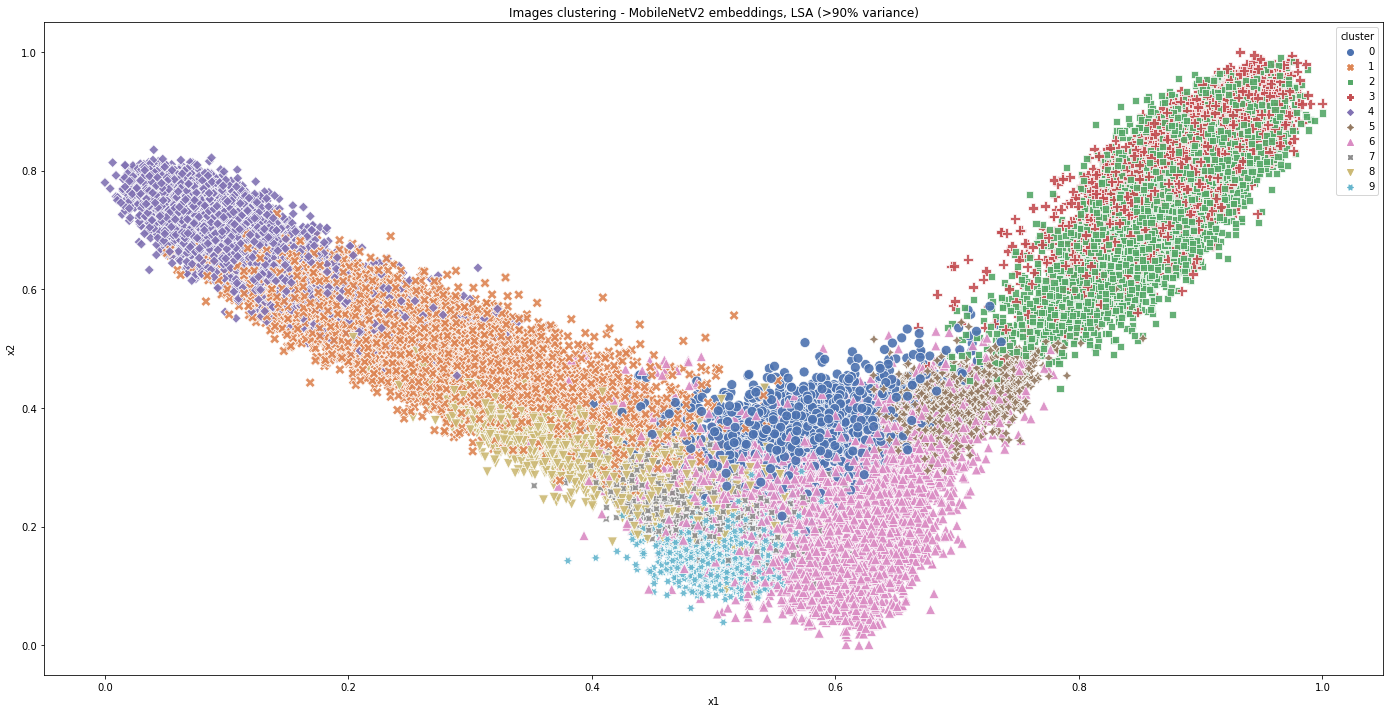

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(12*2,6*2))
ax.set_title('Images clustering - MobileNetV2 embeddings, LSA (>90% variance)')
sns.scatterplot(data=df_image_embeddings_lsa_pca, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)

# Saving all clusters

# Plotting results

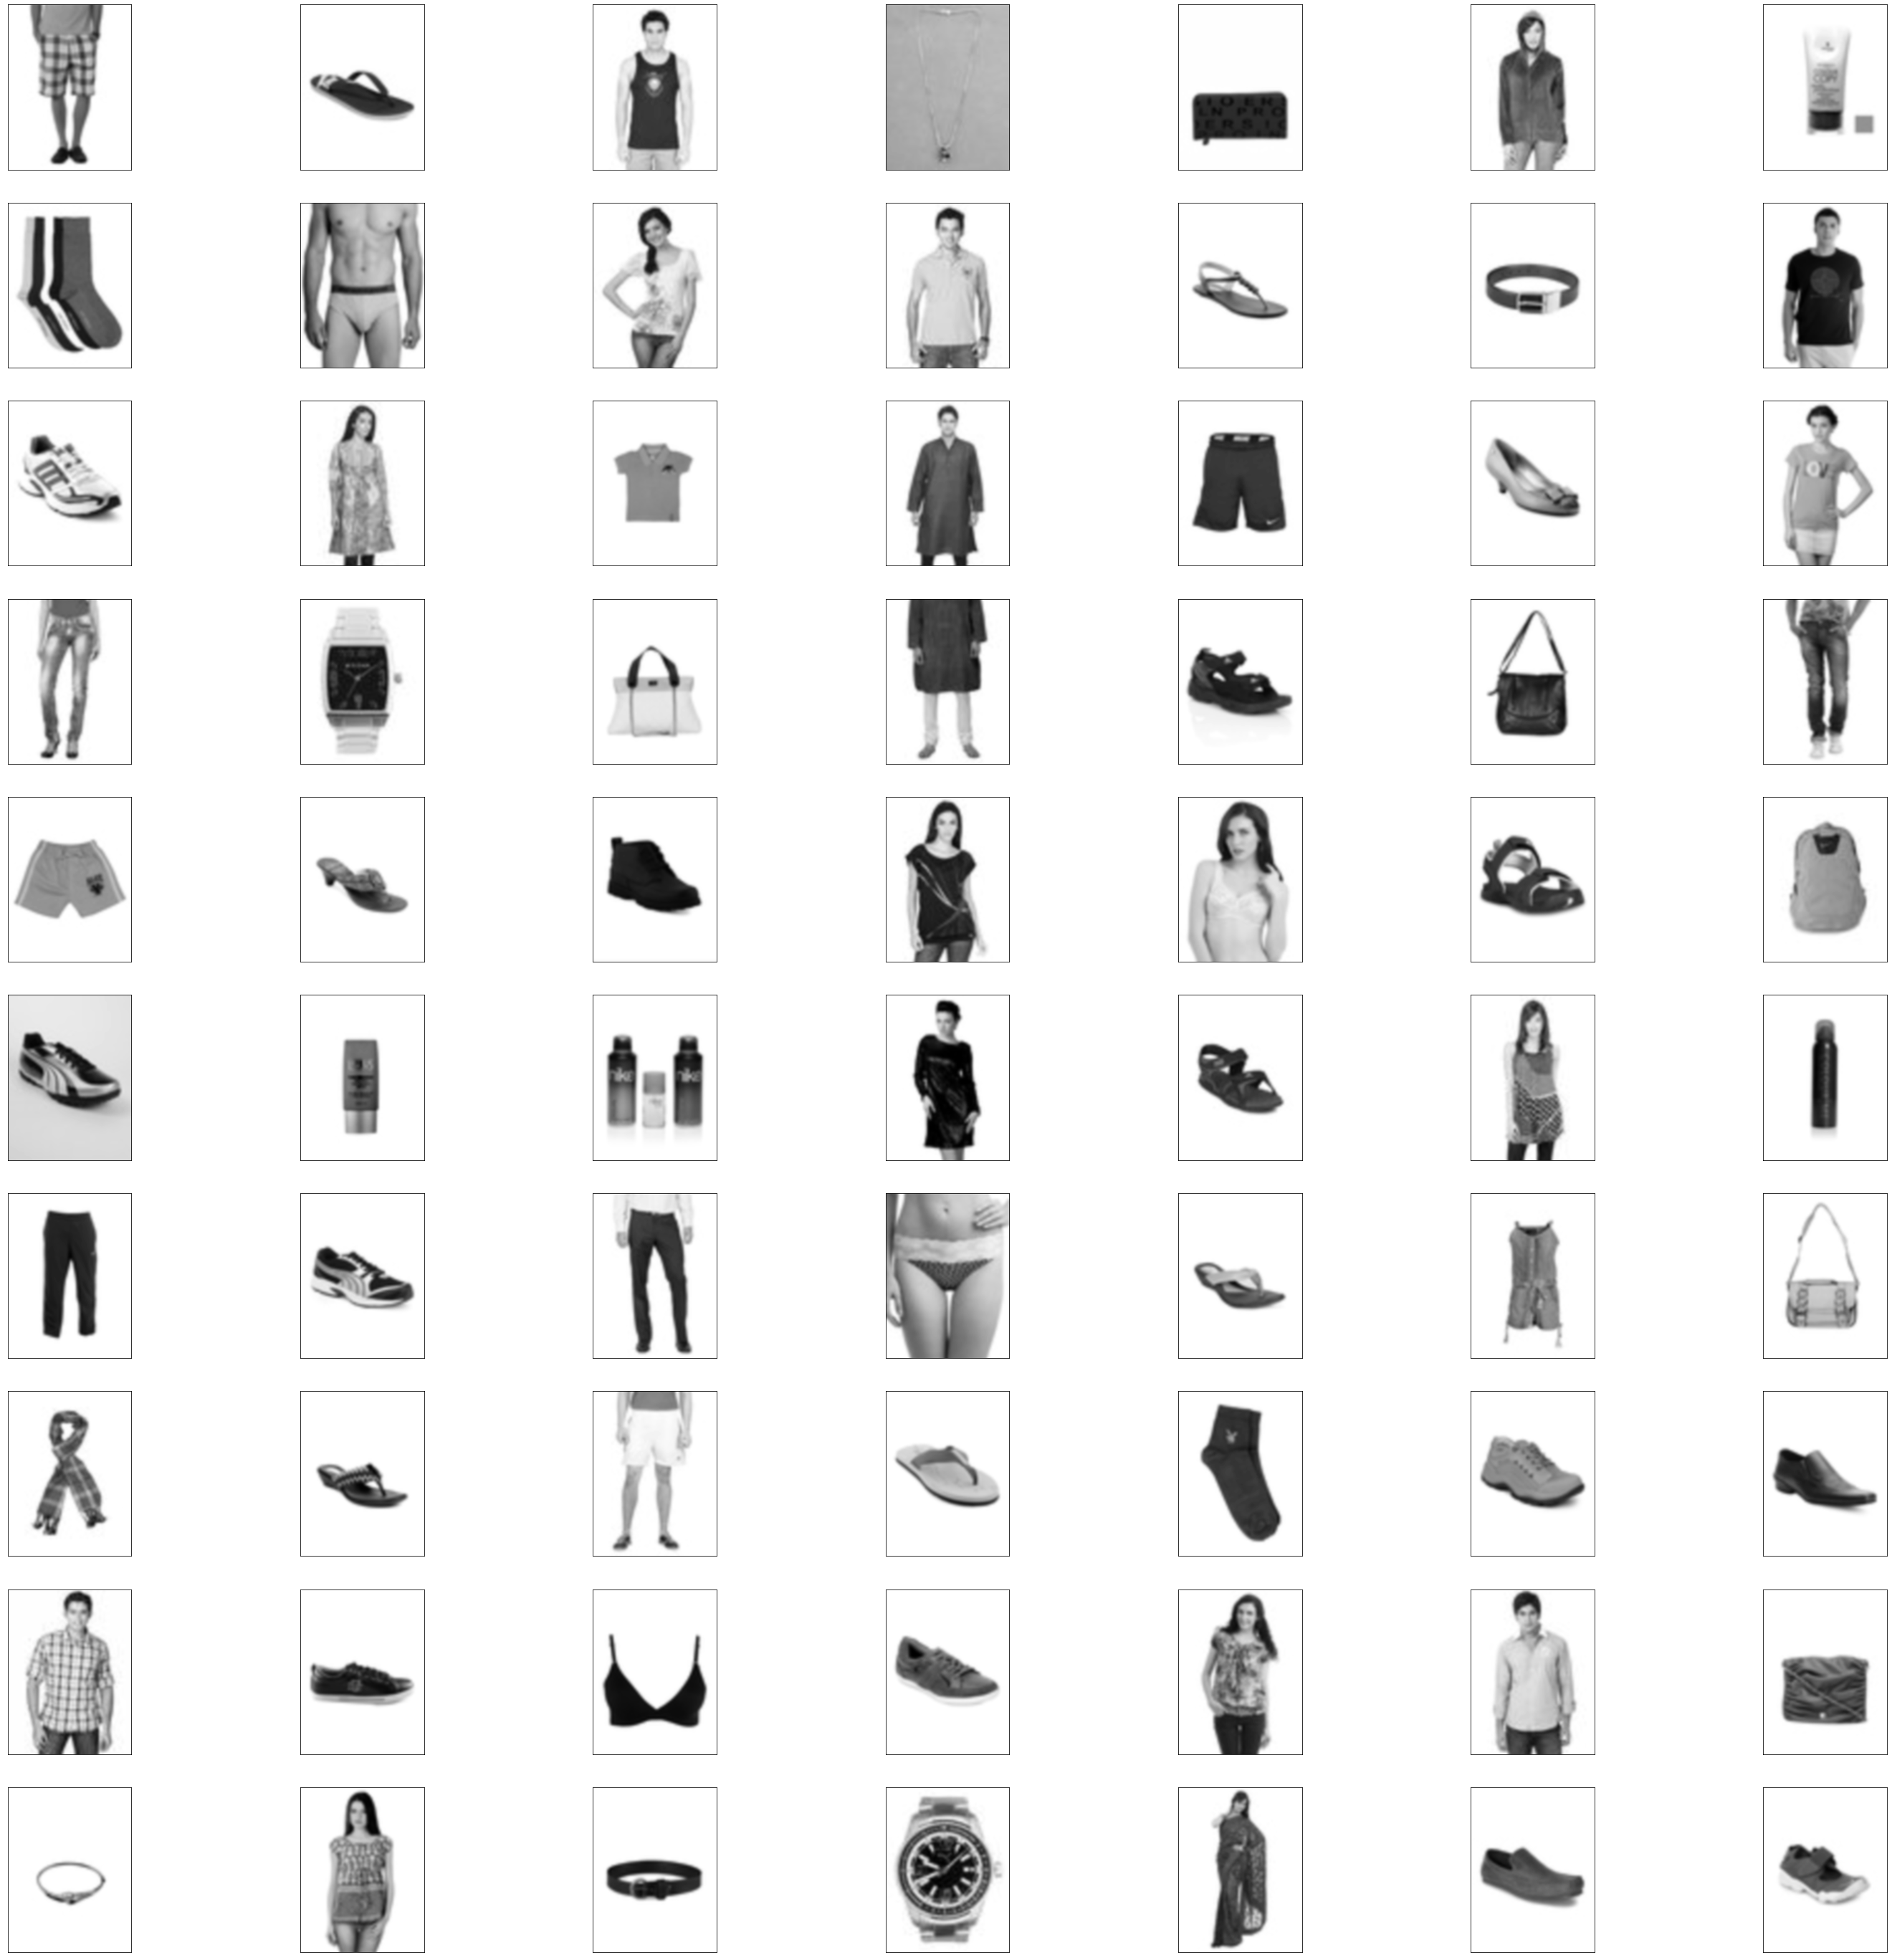

In [165]:
from typing import Union

N_EXAMPLES = 7

def get_image_path(id:Union[int, str]):
  return 'notebooks/xai-survey/images/' + str(id) + '.jpg'

#### Plotting image from each cluster
fig ,axs = plt.subplots(N_CLUSTERS,N_EXAMPLES,figsize=(50,50)) ### making subplot

for i in range(N_CLUSTERS):
  xyz = df_image_embeddings_lsa.loc[df_image_embeddings_lsa['cluster_kmeans'] == i, 'id'].sample(n=N_EXAMPLES).apply(lambda x: get_image_path(x)).tolist()
  # xyz = [get_image_path(x) for x in ['3131', '8231']]
  # print(xyz)
  img = [cv2.imread(abc,0) for abc in xyz]


  #print("Cluster No "+str(i))
  for j in range(min(N_EXAMPLES, len(img))):
    axs[i][j].imshow(img[j], cmap = 'gray', interpolation = 'bicubic')
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])